In [3]:
import gensim
print(gensim.__version__)


4.3.3


In [4]:
!pip install pandas numpy matplotlib seaborn nltk gensim scikit-learn


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import re
import os
from gensim.models import Word2Vec
import warnings
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
import os
import json



warnings.filterwarnings("ignore")

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to C:\Users\Hikmet
[nltk_data]     Ofluoglu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Hikmet
[nltk_data]     Ofluoglu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Hikmet
[nltk_data]     Ofluoglu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
data = pd.read_csv(r"C:\Users\Hikmet Ofluoglu\Desktop\gocmen_sikayetleri_50mb.csv")
data = data.dropna()
data.head()


,id,sikayet_kodu,sikayet_metni,politika_destegi,tarih,ulke
0,1,GUV007,Agent every development say quality.,Sosyal konut desteği,2025-03-23,Türkiye
1,2,GUV007,Beautiful instead ahead despite measure ago cu...,Ücretsiz dil kursları,2024-07-31,Almanya
2,3,IST005,Speak according south recently future choice w...,Asgari ücret denetimi,2024-01-17,Yunanistan
3,4,BRN001,Behavior benefit suggest page southern.,Göçmen koruma birimi,2024-11-17,Yunanistan
4,5,AYR004,Movie win her need stop peace technology offic...,Sosyal konut desteği,2023-06-05,İspanya


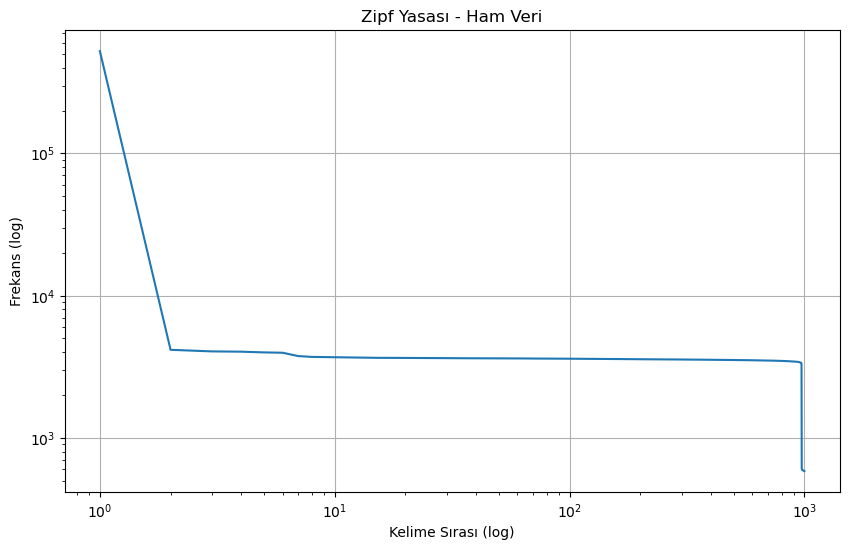

In [4]:
tokenized_words = word_tokenize(' '.join(data['sikayet_metni']))
frequency = Counter(tokenized_words)
most_common = frequency.most_common(1000)
ranks = np.arange(1, len(most_common)+1)
frequencies = [freq for _, freq in most_common]

plt.figure(figsize=(10, 6))
plt.loglog(ranks, frequencies)
plt.xlabel("Kelime Sırası (log)")
plt.ylabel("Frekans (log)")
plt.title("Zipf Yasası - Ham Veri")
plt.grid(True)
plt.show()


In [13]:
stop_words = set(stopwords.words('turkish'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-ZçğıöşüÇĞİÖŞÜ\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    return tokens

def lemmatize_text(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

def stem_text(tokens):
    return [stemmer.stem(token) for token in tokens]


In [14]:
data['tokens'] = data['sikayet_metni'].apply(preprocess_text)
data = data[data['tokens'].str.len() > 0]
data['lemmatized'] = data['tokens'].apply(lemmatize_text)
data['stemmed'] = data['tokens'].apply(stem_text)

data[['lemmatized', 'stemmed']].head()


,lemmatized,stemmed
0,"[agent, every, development, say, quality]","[agent, everi, develop, say, qualiti]"
1,"[beautiful, instead, ahead, despite, measure, ...","[beauti, instead, ahead, despit, measur, ago, ..."
2,"[speak, according, south, recently, future, ch...","[speak, accord, south, recent, futur, choic, w..."
3,"[behavior, benefit, suggest, page, southern]","[behavior, benefit, suggest, page, southern]"
4,"[movie, win, need, stop, peace, technology, of...","[movi, win, need, stop, peac, technolog, offic..."


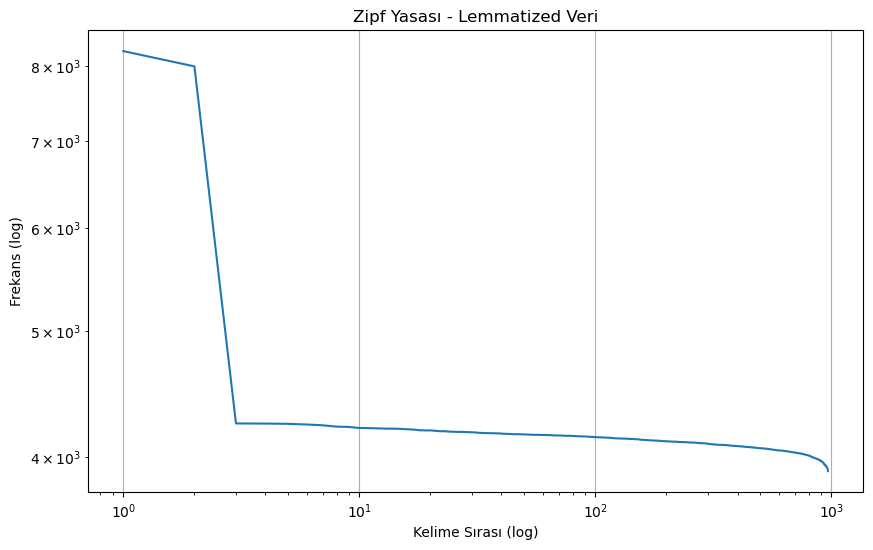

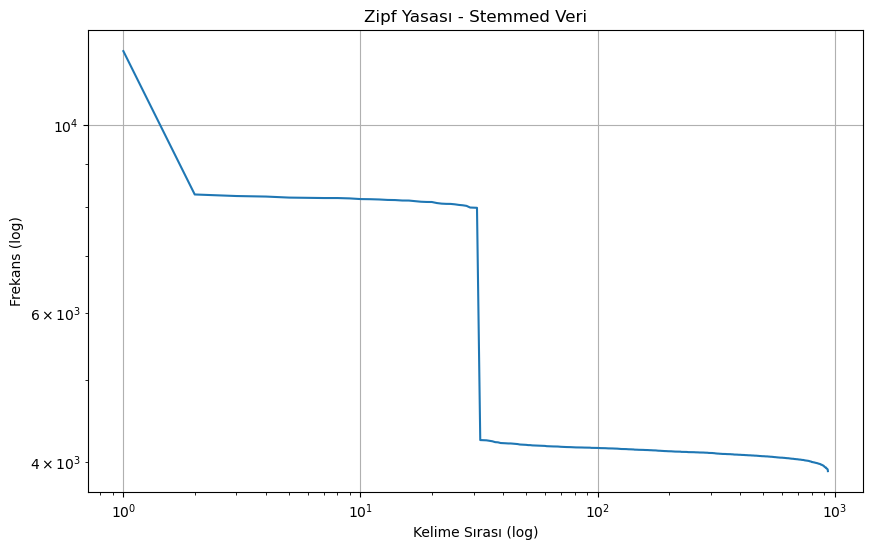

In [15]:
for col in ['lemmatized', 'stemmed']:
    all_words = [word for tokens in data[col] for word in tokens]
    frequency = Counter(all_words)
    most_common = frequency.most_common(1000)
    ranks = np.arange(1, len(most_common)+1)
    frequencies = [freq for _, freq in most_common]

    plt.figure(figsize=(10, 6))
    plt.loglog(ranks, frequencies)
    plt.xlabel("Kelime Sırası (log)")
    plt.ylabel("Frekans (log)")
    plt.title(f"Zipf Yasası - {col.capitalize()} Veri")
    plt.grid(True)
    plt.show()


In [20]:
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

output_dir = r'C:\Users\Hikmet Ofluoglu\Desktop\output3'
os.makedirs(output_dir, exist_ok=True)

# CSV kayıtları
if 'lemmatized' in data.columns:
    data[['lemmatized']].to_csv(os.path.join(output_dir, 'lemmatized_data.csv'), index=False)
    tfidf_lem = TfidfVectorizer()
    X_lem = tfidf_lem.fit_transform(data['lemmatized'].astype(str))
else:
    print("HATA: 'lemmatized' sütunu bulunamadı.")

if 'stemmed' in data.columns:
    data[['stemmed']].to_csv(os.path.join(output_dir, 'stemmed_data.csv'), index=False)
    tfidf_stem = TfidfVectorizer()
    X_stem = tfidf_stem.fit_transform(data['stemmed'].astype(str))
else:
    print("HATA: 'stemmed' sütunu bulunamadı.")

# TF-IDF çıktıları
try:
    tfidf_lem_df = pd.DataFrame(X_lem.toarray(), columns=tfidf_lem.get_feature_names_out())
    tfidf_lem_df.to_csv(os.path.join(output_dir, 'tfidf_lemmatized.csv'), index=False)
except Exception as e:
    print("TF-IDF Lemmatized hatası:", e)

try:
    tfidf_stem_df = pd.DataFrame(X_stem.toarray(), columns=tfidf_stem.get_feature_names_out())
    tfidf_stem_df.to_csv(os.path.join(output_dir, 'tfidf_stemmed.csv'), index=False)
except Exception as e:
    print("TF-IDF Stemmed hatası:", e)

print("✔️ Tüm dosyalar kaydedildi.")


✔️ Tüm dosyalar kaydedildi.


In [17]:
def get_similar_words_tfidf(word, vectorizer):
    feature_names = vectorizer.get_feature_names_out()
    if word not in feature_names:
        print(f"'{word}' kelimesi TF-IDF özelliklerinde bulunamadı.")
        return []

    word_index = feature_names.tolist().index(word)
    tfidf_matrix = vectorizer.transform([' '.join(tokens) for tokens in data['lemmatized']])
    word_vectors = tfidf_matrix.T.toarray()
    similarities = cosine_similarity(word_vectors[word_index].reshape(1, -1), word_vectors).flatten()
    similar_indices = similarities.argsort()[-6:-1][::-1]
    return [feature_names[i] for i in similar_indices]

example_word = 'kayıt'
get_similar_words_tfidf(example_word, tfidf_lem)


'kayıt' kelimesi TF-IDF özelliklerinde bulunamadı.


[]

In [18]:
model = Word2Vec(sentences=data['lemmatized'], vector_size=100, window=5, min_count=2, workers=4, sg=1)
model.save(os.path.join(output_dir, "word2vec.model"))


In [19]:
if example_word in model.wv:
    model.wv.most_similar(example_word, topn=5)
else:
    print(f"'{example_word}' kelimesi Word2Vec modelinde bulunamadı.")


'kayıt' kelimesi Word2Vec modelinde bulunamadı.


In [24]:
parameters = [
    {'model_type': 'cbow', 'window': 2, 'vector_size': 100},
    {'model_type': 'skipgram', 'window': 2, 'vector_size': 100},
    {'model_type': 'cbow', 'window': 4, 'vector_size': 100},
    {'model_type': 'skipgram', 'window': 4, 'vector_size': 100},
    {'model_type': 'cbow', 'window': 2, 'vector_size': 300},
    {'model_type': 'skipgram', 'window': 2, 'vector_size': 300},
    {'model_type': 'cbow', 'window': 4, 'vector_size': 300},
    {'model_type': 'skipgram', 'window': 4, 'vector_size': 300},
]


In [25]:
output_dir = r'C:\Users\Hikmet Ofluoglu\Desktop\output3\word2vec_models'
os.makedirs(output_dir, exist_ok=True)

def tokenize_column(text_series):
    return [str(row).split() for row in text_series]



for col in ['lemmatized', 'stemmed']:
    if col not in data.columns:
        print(f"HATA: '{col}' sütunu bulunamadı.")
        continue

    sentences = tokenize_column(data[col])

    for i, params in enumerate(parameters):
        sg_value = 1 if params['model_type'] == 'skipgram' else 0
        model = Word2Vec(
            sentences=sentences,
            vector_size=params['vector_size'],
            window=params['window'],
            sg=sg_value,
            min_count=1,
            workers=4,
            epochs=10
        )

        model_name = f"word2vec_{col}_{params['model_type']}_win{params['window']}_vec{params['vector_size']}.model"
        model_path = os.path.join(output_dir, model_name)
        model.save(model_path)

        print(f"✔️ Model kaydedildi: {model_name}")


✔️ Model kaydedildi: word2vec_lemmatized_cbow_win2_vec100.model
✔️ Model kaydedildi: word2vec_lemmatized_skipgram_win2_vec100.model
✔️ Model kaydedildi: word2vec_lemmatized_cbow_win4_vec100.model
✔️ Model kaydedildi: word2vec_lemmatized_skipgram_win4_vec100.model
✔️ Model kaydedildi: word2vec_lemmatized_cbow_win2_vec300.model
✔️ Model kaydedildi: word2vec_lemmatized_skipgram_win2_vec300.model
✔️ Model kaydedildi: word2vec_lemmatized_cbow_win4_vec300.model
✔️ Model kaydedildi: word2vec_lemmatized_skipgram_win4_vec300.model
✔️ Model kaydedildi: word2vec_stemmed_cbow_win2_vec100.model
✔️ Model kaydedildi: word2vec_stemmed_skipgram_win2_vec100.model
✔️ Model kaydedildi: word2vec_stemmed_cbow_win4_vec100.model
✔️ Model kaydedildi: word2vec_stemmed_skipgram_win4_vec100.model
✔️ Model kaydedildi: word2vec_stemmed_cbow_win2_vec300.model
✔️ Model kaydedildi: word2vec_stemmed_skipgram_win2_vec300.model
✔️ Model kaydedildi: word2vec_stemmed_cbow_win4_vec300.model
✔️ Model kaydedildi: word2vec_ste

In [31]:

example_tokens = ['agent', 'everi', 'develop', 'say', 'qualiti']


example_text = " ".join(example_tokens)

print("Örnek giriş metni:")
print(example_text)


Örnek giriş metni:
agent everi develop say qualiti


In [39]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


lemma_data = pd.read_csv('lemmatized_data.csv')
stem_data = pd.read_csv('stemmed_data.csv')


sample_index_lem = 0
sample_index_stem = 0


vectorizer_lem = TfidfVectorizer()
vectorizer_stem = TfidfVectorizer()


tfidf_lem = vectorizer_lem.fit_transform(lemma_data['lemmatized'])
sample_vec_lem = tfidf_lem[sample_index_lem]


similarities_lem = cosine_similarity(sample_vec_lem, tfidf_lem)[0]


top5_indices_lem = np.argsort(similarities_lem)[-6:-1][::-1]

print("Lemmatized veri setinden en benzer 5 cümle:")
for idx in top5_indices_lem:
    print(f"Benzerlik: {similarities_lem[idx]:.4f} - Cümle: {lemma_data.loc[idx, 'lemmatized']}")


tfidf_stem = vectorizer_stem.fit_transform(stem_data['stemmed'])
sample_vec_stem = tfidf_stem[sample_index_stem]


similarities_stem = cosine_similarity(sample_vec_stem, tfidf_stem)[0]


top5_indices_stem = np.argsort(similarities_stem)[-6:-1][::-1]

print("\nStemmed veri setinden en benzer 5 cümle:")
for idx in top5_indices_stem:
    print(f"Benzerlik: {similarities_stem[idx]:.4f} - Cümle: {stem_data.loc[idx, 'stemmed']}")


Lemmatized veri setinden en benzer 5 cümle:
Benzerlik: 0.5159 - Cümle: ['quality', 'likely', 'development']
Benzerlik: 0.5065 - Cümle: ['south', 'theory', 'agent', 'quality', 'investment', 'every', 'foreign']
Benzerlik: 0.4743 - Cümle: ['great', 'quality', 'development', 'woman', 'concern', 'message', 'eat', 'say']
Benzerlik: 0.4479 - Cümle: ['challenge', 'loss', 'want', 'say', 'agent', 'development', 'world', 'shoulder', 'turn']
Benzerlik: 0.4478 - Cümle: ['service', 'say', 'sell', 'agent']

Stemmed veri setinden en benzer 5 cümle:
Benzerlik: 0.6528 - Cümle: ['qualiti', 'develop', 'write', 'agent']
Benzerlik: 0.5815 - Cümle: ['develop', 'suffer', 'qualiti', 'water', 'say']
Benzerlik: 0.5182 - Cümle: ['south', 'theori', 'agent', 'qualiti', 'invest', 'everi', 'foreign']
Benzerlik: 0.5081 - Cümle: ['qualiti', 'like', 'develop']
Benzerlik: 0.4888 - Cümle: ['without', 'develop', 'everi']


In [41]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

base_path = r"C:\Users\Hikmet Ofluoglu\Desktop\output3\word2vec_models"

model_paths = [
    base_path + r"\word2vec_lemmatized_cbow_win2_vec100.model",
    base_path + r"\word2vec_lemmatized_skipgram_win2_vec100.model",
    base_path + r"\word2vec_lemmatized_cbow_win4_vec100.model",
    base_path + r"\word2vec_lemmatized_skipgram_win4_vec100.model",
    base_path + r"\word2vec_lemmatized_cbow_win2_vec300.model",
    base_path + r"\word2vec_lemmatized_skipgram_win2_vec300.model",
    base_path + r"\word2vec_lemmatized_cbow_win4_vec300.model",
    base_path + r"\word2vec_lemmatized_skipgram_win4_vec300.model",
    base_path + r"\word2vec_stemmed_cbow_win2_vec100.model",
    base_path + r"\word2vec_stemmed_skipgram_win2_vec100.model",
    base_path + r"\word2vec_stemmed_cbow_win4_vec100.model",
    base_path + r"\word2vec_stemmed_skipgram_win4_vec100.model",
    base_path + r"\word2vec_stemmed_cbow_win2_vec300.model",
    base_path + r"\word2vec_stemmed_skipgram_win2_vec300.model",
    base_path + r"\word2vec_stemmed_cbow_win4_vec300.model",
    base_path + r"\word2vec_stemmed_skipgram_win4_vec300.model",
]

lemma_data = pd.read_csv('lemmatized_data.csv')
stem_data = pd.read_csv('stemmed_data.csv')

def tokenize(text):
    return text.split()

def sentence_vector(model, sentence_tokens):
    vectors = [model.wv[word] for word in sentence_tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

def print_similar_sentences_word2vec(model, corpus, sample_index, model_name):
    tokenized_corpus = corpus.apply(tokenize)
    corpus_vectors = np.array([sentence_vector(model, tokens) for tokens in tokenized_corpus])
    sample_vec = corpus_vectors[sample_index].reshape(1, -1)
    similarities = cosine_similarity(sample_vec, corpus_vectors)[0]
    top_indices = np.argsort(similarities)[-6:][::-1]
    print(f"\nModel: {model_name} - En benzer 5 cümle (indeks {sample_index} için):")
    count = 0
    for idx in top_indices:
        if idx == sample_index:
            continue
        print(f"Benzerlik: {similarities[idx]:.4f} - Cümle: {corpus.iloc[idx]}")
        count += 1
        if count == 5:
            break

sample_index_lem = 0
sample_index_stem = 0

for model_path in model_paths:
    try:
        model = Word2Vec.load(model_path)
    except Exception as e:
        print(f"Model yüklenirken hata oluştu: {model_path} -> {e}")
        continue

    if 'lemmatized' in model_path:
        corpus = lemma_data['lemmatized']
        sample_idx = sample_index_lem
    elif 'stemmed' in model_path:
        corpus = stem_data['stemmed']
        sample_idx = sample_index_stem
    else:
        print(f"Veri seti bilinmiyor: {model_path}")
        continue

    print_similar_sentences_word2vec(model, corpus, sample_idx, model_path)



Model: C:\Users\Hikmet Ofluoglu\Desktop\output3\word2vec_models\word2vec_lemmatized_cbow_win2_vec100.model - En benzer 5 cümle (indeks 0 için):
Benzerlik: 0.9618 - Cümle: ['friend', 'reason', 'development', 'say', 'ball', 'top', 'keep']
Benzerlik: 0.9607 - Cümle: ['black', 'development', 'security', 'every', 'ability']
Benzerlik: 0.9605 - Cümle: ['institution', 'team', 'ago', 'say', 'say', 'house', 'life', 'best', 'still']
Benzerlik: 0.9600 - Cümle: ['modern', 'subject', 'every', 'first', 'say', 'fund', 'story']
Benzerlik: 0.9591 - Cümle: ['enter', 'relationship', 'development', 'say', 'piece']

Model: C:\Users\Hikmet Ofluoglu\Desktop\output3\word2vec_models\word2vec_lemmatized_skipgram_win2_vec100.model - En benzer 5 cümle (indeks 0 için):
Benzerlik: 0.9008 - Cümle: ['friend', 'reason', 'development', 'say', 'ball', 'top', 'keep']
Benzerlik: 0.8987 - Cümle: ['car', 'congress', 'describe', 'plan', 'research', 'test', 'reduce']
Benzerlik: 0.8975 - Cümle: ['reveal', 'development', 'ente

In [45]:
import pandas as pd
import numpy as np
import os
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity


model_paths = [
    r"C:\Users\Hikmet Ofluoglu\Desktop\output3\word2vec_models\word2vec_lemmatized_cbow_win2_vec100.model",
    r"C:\Users\Hikmet Ofluoglu\Desktop\output3\word2vec_models\word2vec_lemmatized_skipgram_win2_vec100.model",
    r"C:\Users\Hikmet Ofluoglu\Desktop\output3\word2vec_models\word2vec_lemmatized_cbow_win4_vec100.model",
    r"C:\Users\Hikmet Ofluoglu\Desktop\output3\word2vec_models\word2vec_lemmatized_skipgram_win4_vec100.model",
    r"C:\Users\Hikmet Ofluoglu\Desktop\output3\word2vec_models\word2vec_lemmatized_cbow_win2_vec300.model",
    r"C:\Users\Hikmet Ofluoglu\Desktop\output3\word2vec_models\word2vec_lemmatized_skipgram_win2_vec300.model",
    r"C:\Users\Hikmet Ofluoglu\Desktop\output3\word2vec_models\word2vec_lemmatized_cbow_win4_vec300.model",
    r"C:\Users\Hikmet Ofluoglu\Desktop\output3\word2vec_models\word2vec_lemmatized_skipgram_win4_vec300.model",
    r"C:\Users\Hikmet Ofluoglu\Desktop\output3\word2vec_models\word2vec_stemmed_cbow_win2_vec100.model",
    r"C:\Users\Hikmet Ofluoglu\Desktop\output3\word2vec_models\word2vec_stemmed_skipgram_win2_vec100.model",
    r"C:\Users\Hikmet Ofluoglu\Desktop\output3\word2vec_models\word2vec_stemmed_cbow_win4_vec100.model",
    r"C:\Users\Hikmet Ofluoglu\Desktop\output3\word2vec_models\word2vec_stemmed_skipgram_win4_vec100.model",
    r"C:\Users\Hikmet Ofluoglu\Desktop\output3\word2vec_models\word2vec_stemmed_cbow_win2_vec300.model",
    r"C:\Users\Hikmet Ofluoglu\Desktop\output3\word2vec_models\word2vec_stemmed_skipgram_win2_vec300.model",
    r"C:\Users\Hikmet Ofluoglu\Desktop\output3\word2vec_models\word2vec_stemmed_cbow_win4_vec300.model",
    r"C:\Users\Hikmet Ofluoglu\Desktop\output3\word2vec_models\word2vec_stemmed_skipgram_win4_vec300.model"
]


def get_sentence_vector(sentence, model):
    words = sentence.split()
    vecs = [model.wv[w] for w in words if w in model.wv]
    if vecs:
        return np.mean(vecs, axis=0)
    else:
        return np.zeros(model.vector_size)

def get_top5_similar_sentences(model, data_df, input_index=0, text_col='lemmatized'):
    input_sentence = data_df.loc[input_index, text_col]
    input_vec = get_sentence_vector(input_sentence, model).reshape(1, -1)
    sentence_vecs = np.array([get_sentence_vector(sent, model) for sent in data_df[text_col]])
    sims = cosine_similarity(input_vec, sentence_vecs)[0]
    top5_idx = sims.argsort()[-6:-1][::-1]  # Kendisi hariç en yüksek 5 indeks
    top5_sentences = data_df.loc[top5_idx, text_col].tolist()
    return set(top5_sentences)

top5_results = {}

for model_path in model_paths:
    print(f"Yükleniyor: {model_path}")
    model = Word2Vec.load(model_path)
    if 'lemmatized' in model_path:
        data_df = lemma_data
        text_col = 'lemmatized'
    else:
        data_df = stem_data
        text_col = 'stemmed'

    top5_set = get_top5_similar_sentences(model, data_df, input_index=0, text_col=text_col)
    model_name = os.path.basename(model_path).replace('.model', '')
    top5_results[model_name] = top5_set


model_names = list(top5_results.keys())
matrix = []

for i, m1 in enumerate(model_names):
    row = []
    s1 = top5_results[m1]
    for j, m2 in enumerate(model_names):
        s2 = top5_results[m2]
        inter = len(s1.intersection(s2))
        union = len(s1.union(s2))
        score = inter / union if union > 0 else 0
        row.append(score)
    matrix.append(row)

jaccard_df = pd.DataFrame(matrix, index=model_names, columns=model_names)

# Excel olarak masaüstüne kaydet
desktop = os.path.join(os.path.expanduser("~"), "Desktop")
file_path = os.path.join(desktop, "jaccard_similarity_matrix_16models.xlsx")
jaccard_df.to_excel(file_path)

print(f"Jaccard benzerlik matrisi başarıyla kaydedildi: {file_path}")


Yükleniyor: C:\Users\Hikmet Ofluoglu\Desktop\output3\word2vec_models\word2vec_lemmatized_cbow_win2_vec100.model
Yükleniyor: C:\Users\Hikmet Ofluoglu\Desktop\output3\word2vec_models\word2vec_lemmatized_skipgram_win2_vec100.model
Yükleniyor: C:\Users\Hikmet Ofluoglu\Desktop\output3\word2vec_models\word2vec_lemmatized_cbow_win4_vec100.model
Yükleniyor: C:\Users\Hikmet Ofluoglu\Desktop\output3\word2vec_models\word2vec_lemmatized_skipgram_win4_vec100.model
Yükleniyor: C:\Users\Hikmet Ofluoglu\Desktop\output3\word2vec_models\word2vec_lemmatized_cbow_win2_vec300.model
Yükleniyor: C:\Users\Hikmet Ofluoglu\Desktop\output3\word2vec_models\word2vec_lemmatized_skipgram_win2_vec300.model
Yükleniyor: C:\Users\Hikmet Ofluoglu\Desktop\output3\word2vec_models\word2vec_lemmatized_cbow_win4_vec300.model
Yükleniyor: C:\Users\Hikmet Ofluoglu\Desktop\output3\word2vec_models\word2vec_lemmatized_skipgram_win4_vec300.model
Yükleniyor: C:\Users\Hikmet Ofluoglu\Desktop\output3\word2vec_models\word2vec_stemmed_cb